In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess import get_data
from single_search import search_model_eval, combine

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,256,1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data
# tf.config.run_functions_eagerly(False)

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [28]:
%matplotlib inline
NUM_SAMPLES = 20000
plate = np.load('../../real_filtered.npy')[:77687]

print(plate.shape)
print("Creating True")
data = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=30, factor =0.1)
data = combine(load_data_ED(data))

print("Creating False")
false_data = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=30))
false_data = load_data_ED(false_data)

print("Creating True")
true_data_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =0.1)
true_data_1 = load_data_ED(true_data_1)

true_data_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =0.1)
true_data_2 = load_data_ED(true_data_2)

(77687, 6, 16, 256)
Creating True
(20000, 6, 16, 256)
Creating False
(120000, 6, 16, 256)
Creating True
(60000, 6, 16, 256)
(60000, 6, 16, 256)


In [29]:
true_data = np.concatenate((true_data_1,true_data_2),axis=0)
print(true_data.shape)

(120000, 6, 16, 256, 1)


In [30]:
NUM_SAMPLES = 1000

print(plate.shape)
print("Creating True")
data_test = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES,  snr_base=20, snr_range=30, factor =0.1)
data_test = combine(load_data_ED(data_test))

print("Creating False")
false_data_test = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=20, snr_range=30))
false_data_test = load_data_ED(false_data_test)


print("Creating True")
true_data_test_1 = create_full_cadence(create_true_faster, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =0.1)
true_data_test_1 = load_data_ED(true_data_test_1)

true_data_test_2 = create_full_cadence(create_true_single_shot, plate = plate, samples = NUM_SAMPLES*3,  snr_base=20, snr_range=30, factor =0.1)
true_data_test_2 = load_data_ED(true_data_test_2)


true_data_test = np.concatenate((true_data_test_1,true_data_test_2),axis=0)
print(true_data_test.shape)

(77687, 6, 16, 256)
Creating True
(1000, 6, 16, 256)
Creating False
(6000, 6, 16, 256)
Creating True
(3000, 6, 16, 256)
(3000, 6, 16, 256)
(6000, 6, 16, 256, 1)


In [35]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,  **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        alpha=2
        beta=2
        self.alpha = alpha
        self.beta = beta
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(15*true_loss+false_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(15*true_loss+false_loss)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result()
        }

In [36]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [37]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [38]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [39]:
def build_model():
    latent_dim = 8
    dens_lay = 512
    kernel = (3,3)
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dens_lay, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu")(latent_inputs)
    x = layers.Dense(1* 16 * 256, activation="relu")(x)
    x = layers.Reshape((1,16, 256))(x)
    x = layers.Conv2DTranspose(256, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 16, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 8, 128, 16)   160         in

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae_best_model.hdf5",
    monitor='val_loss',
    save_weights_only=False,
    mode='min',
    save_best_only=True)

history = model.fit(x = [data,true_data,false_data ],y= data[:,:,:,:], epochs=800, batch_size=3000, 
          validation_data=([data_test,true_data_test,false_data_test ], data_test),validation_batch_size=6000)

Epoch 1/800
40/40 [==============================] - 79s 1s/step - loss: 3425.5552 - reconstruction_loss: 2755.6616 - kl_loss: 7.1995 - false_loss: 29.4725 - true_loss: 18.5542 - val_loss: 3178.6069 - val_reconstruction_loss: 2691.4705 - val_kl_loss: 7.5068 - val_false_loss: 13.5630 - val_true_loss: 14.8332
Epoch 2/800
40/40 [==============================] - 43s 1s/step - loss: 3155.7933 - reconstruction_loss: 2660.0469 - kl_loss: 7.9242 - false_loss: 18.0062 - true_loss: 15.7420 - val_loss: 3163.6895 - val_reconstruction_loss: 2674.6387 - val_kl_loss: 8.4093 - val_false_loss: 13.6466 - val_true_loss: 14.8313
Epoch 3/800
40/40 [==============================] - 45s 1s/step - loss: 3137.9779 - reconstruction_loss: 2643.9497 - kl_loss: 8.6571 - false_loss: 16.4348 - true_loss: 15.3656 - val_loss: 3155.6394 - val_reconstruction_loss: 2666.6848 - val_kl_loss: 8.4249 - val_false_loss: 13.7689 - val_true_loss: 14.8189
Epoch 4/800
40/40 [==============================] - 45s 1s/step - loss: 

40/40 [==============================] - 43s 1s/step - loss: 2845.0044 - reconstruction_loss: 2621.1829 - kl_loss: 30.8135 - false_loss: 18.2663 - true_loss: 6.4358 - val_loss: 2924.0815 - val_reconstruction_loss: 2645.0869 - val_kl_loss: 28.4576 - val_false_loss: 18.2938 - val_true_loss: 6.1830
Epoch 54/800
40/40 [==============================] - 43s 1s/step - loss: 2845.7038 - reconstruction_loss: 2625.9805 - kl_loss: 30.3400 - false_loss: 18.3124 - true_loss: 6.3893 - val_loss: 2922.7869 - val_reconstruction_loss: 2644.8579 - val_kl_loss: 28.5019 - val_false_loss: 18.3490 - val_true_loss: 6.1409
Epoch 55/800
40/40 [==============================] - 43s 1s/step - loss: 2842.8067 - reconstruction_loss: 2620.4895 - kl_loss: 30.8929 - false_loss: 18.3572 - true_loss: 6.3456 - val_loss: 2921.4746 - val_reconstruction_loss: 2644.6365 - val_kl_loss: 28.5673 - val_false_loss: 18.4021 - val_true_loss: 6.0966
Epoch 56/800
40/40 [==============================] - 43s 1s/step - loss: 2845.8835

40/40 [==============================] - 44s 1s/step - loss: 2820.0674 - reconstruction_loss: 2607.3013 - kl_loss: 32.1932 - false_loss: 19.7310 - true_loss: 5.0941 - val_loss: 2883.6580 - val_reconstruction_loss: 2636.0706 - val_kl_loss: 30.1635 - val_false_loss: 19.9491 - val_true_loss: 4.9121
Epoch 106/800
40/40 [==============================] - 44s 1s/step - loss: 2829.6984 - reconstruction_loss: 2629.9360 - kl_loss: 30.7273 - false_loss: 19.7483 - true_loss: 5.0796 - val_loss: 2883.4868 - val_reconstruction_loss: 2636.0967 - val_kl_loss: 30.1533 - val_false_loss: 19.9704 - val_true_loss: 4.9048
Epoch 107/800
40/40 [==============================] - 44s 1s/step - loss: 2842.6058 - reconstruction_loss: 2615.5359 - kl_loss: 29.9889 - false_loss: 19.7626 - true_loss: 5.0697 - val_loss: 2883.0554 - val_reconstruction_loss: 2635.9937 - val_kl_loss: 30.1708 - val_false_loss: 19.9912 - val_true_loss: 4.8913
Epoch 108/800
40/40 [==============================] - 43s 1s/step - loss: 2824.1

40/40 [==============================] - 43s 1s/step - loss: 2812.2813 - reconstruction_loss: 2605.1494 - kl_loss: 32.5624 - false_loss: 20.4298 - true_loss: 4.5554 - val_loss: 2867.0266 - val_reconstruction_loss: 2631.5974 - val_kl_loss: 30.8150 - val_false_loss: 20.7185 - val_true_loss: 4.4121
Epoch 158/800
40/40 [==============================] - 43s 1s/step - loss: 2813.4127 - reconstruction_loss: 2605.3601 - kl_loss: 32.5348 - false_loss: 20.4406 - true_loss: 4.5473 - val_loss: 2866.7493 - val_reconstruction_loss: 2631.5046 - val_kl_loss: 30.8284 - val_false_loss: 20.7294 - val_true_loss: 4.4043
Epoch 159/800
40/40 [==============================] - 43s 1s/step - loss: 2812.9846 - reconstruction_loss: 2605.3191 - kl_loss: 32.5325 - false_loss: 20.4517 - true_loss: 4.5392 - val_loss: 2866.4683 - val_reconstruction_loss: 2631.4087 - val_kl_loss: 30.8402 - val_false_loss: 20.7395 - val_true_loss: 4.3967
Epoch 160/800
40/40 [==============================] - 44s 1s/step - loss: 2812.2

40/40 [==============================] - 44s 1s/step - loss: 2809.1799 - reconstruction_loss: 2604.6714 - kl_loss: 32.5979 - false_loss: 20.8418 - true_loss: 4.2559 - val_loss: 2857.0571 - val_reconstruction_loss: 2628.7256 - val_kl_loss: 31.2465 - val_false_loss: 21.1688 - val_true_loss: 4.1167
Epoch 210/800
40/40 [==============================] - 44s 1s/step - loss: 2810.4972 - reconstruction_loss: 2604.8665 - kl_loss: 32.6105 - false_loss: 20.8500 - true_loss: 4.2507 - val_loss: 2856.8835 - val_reconstruction_loss: 2628.6675 - val_kl_loss: 31.2530 - val_false_loss: 21.1776 - val_true_loss: 4.1119
Epoch 211/800
40/40 [==============================] - 44s 1s/step - loss: 2811.1830 - reconstruction_loss: 2604.7974 - kl_loss: 32.5080 - false_loss: 20.8586 - true_loss: 4.2456 - val_loss: 2856.7073 - val_reconstruction_loss: 2628.6069 - val_kl_loss: 31.2606 - val_false_loss: 21.1867 - val_true_loss: 4.1069
Epoch 212/800
40/40 [==============================] - 44s 1s/step - loss: 2809.8

40/40 [==============================] - 44s 1s/step - loss: 2809.9390 - reconstruction_loss: 2609.2144 - kl_loss: 30.9566 - false_loss: 21.2517 - true_loss: 4.0415 - val_loss: 2849.7690 - val_reconstruction_loss: 2626.2922 - val_kl_loss: 31.4011 - val_false_loss: 21.5821 - val_true_loss: 3.9170
Epoch 262/800
40/40 [==============================] - 44s 1s/step - loss: 2807.6118 - reconstruction_loss: 2604.0886 - kl_loss: 30.9499 - false_loss: 21.2588 - true_loss: 4.0385 - val_loss: 2849.6396 - val_reconstruction_loss: 2626.2480 - val_kl_loss: 31.4011 - val_false_loss: 21.5907 - val_true_loss: 3.9136
Epoch 263/800
40/40 [==============================] - 43s 1s/step - loss: 2806.0311 - reconstruction_loss: 2603.3035 - kl_loss: 31.5371 - false_loss: 21.2673 - true_loss: 4.0348 - val_loss: 2849.5125 - val_reconstruction_loss: 2626.2041 - val_kl_loss: 31.4019 - val_false_loss: 21.5989 - val_true_loss: 3.9102
Epoch 264/800
40/40 [==============================] - 43s 1s/step - loss: 2804.9

40/40 [==============================] - 43s 1s/step - loss: 2830.2828 - reconstruction_loss: 2607.8159 - kl_loss: 38.2750 - false_loss: 21.5121 - true_loss: 3.9082 - val_loss: 2845.7700 - val_reconstruction_loss: 2624.9275 - val_kl_loss: 31.6111 - val_false_loss: 21.8114 - val_true_loss: 3.8000
Epoch 314/800
40/40 [==============================] - 43s 1s/step - loss: 2833.2218 - reconstruction_loss: 2608.1575 - kl_loss: 37.8268 - false_loss: 21.5048 - true_loss: 3.9074 - val_loss: 2845.7471 - val_reconstruction_loss: 2624.9087 - val_kl_loss: 31.6347 - val_false_loss: 21.8055 - val_true_loss: 3.7986
Epoch 315/800
40/40 [==============================] - 43s 1s/step - loss: 2830.1004 - reconstruction_loss: 2608.0730 - kl_loss: 38.1656 - false_loss: 21.4979 - true_loss: 3.9064 - val_loss: 2845.7305 - val_reconstruction_loss: 2624.8962 - val_kl_loss: 31.6563 - val_false_loss: 21.7991 - val_true_loss: 3.7975
Epoch 316/800
40/40 [==============================] - 43s 1s/step - loss: 2830.0

40/40 [==============================] - 43s 1s/step - loss: 2808.5873 - reconstruction_loss: 2604.4895 - kl_loss: 30.9279 - false_loss: 21.4958 - true_loss: 3.8373 - val_loss: 2843.3054 - val_reconstruction_loss: 2623.8171 - val_kl_loss: 32.0564 - val_false_loss: 21.8010 - val_true_loss: 3.7258
Epoch 366/800
40/40 [==============================] - 43s 1s/step - loss: 2808.1256 - reconstruction_loss: 2603.5950 - kl_loss: 31.1669 - false_loss: 21.5019 - true_loss: 3.8354 - val_loss: 2843.2373 - val_reconstruction_loss: 2623.7930 - val_kl_loss: 32.0552 - val_false_loss: 21.8067 - val_true_loss: 3.7240
Epoch 367/800
40/40 [==============================] - 43s 1s/step - loss: 2808.4241 - reconstruction_loss: 2603.9966 - kl_loss: 31.1257 - false_loss: 21.5079 - true_loss: 3.8336 - val_loss: 2843.1714 - val_reconstruction_loss: 2623.7688 - val_kl_loss: 32.0533 - val_false_loss: 21.8105 - val_true_loss: 3.7225
Epoch 368/800
40/40 [==============================] - 43s 1s/step - loss: 2807.1

40/40 [==============================] - 43s 1s/step - loss: 2801.2514 - reconstruction_loss: 2603.1035 - kl_loss: 30.1154 - false_loss: 21.8388 - true_loss: 3.7377 - val_loss: 2839.8423 - val_reconstruction_loss: 2622.7065 - val_kl_loss: 31.9019 - val_false_loss: 22.1099 - val_true_loss: 3.6371
Epoch 418/800
40/40 [==============================] - 43s 1s/step - loss: 2799.9899 - reconstruction_loss: 2602.5054 - kl_loss: 30.3316 - false_loss: 21.8455 - true_loss: 3.7358 - val_loss: 2839.7766 - val_reconstruction_loss: 2622.6860 - val_kl_loss: 31.8995 - val_false_loss: 22.1161 - val_true_loss: 3.6353
Epoch 419/800
40/40 [==============================] - 43s 1s/step - loss: 2801.3449 - reconstruction_loss: 2602.8513 - kl_loss: 30.3901 - false_loss: 21.8522 - true_loss: 3.7338 - val_loss: 2839.7100 - val_reconstruction_loss: 2622.6658 - val_kl_loss: 31.8956 - val_false_loss: 22.1217 - val_true_loss: 3.6337
Epoch 420/800
40/40 [==============================] - 43s 1s/step - loss: 2798.2

40/40 [==============================] - 43s 1s/step - loss: 2759.7246 - reconstruction_loss: 2604.2546 - kl_loss: 25.9288 - false_loss: 21.7274 - true_loss: 3.6460 - val_loss: 2836.4807 - val_reconstruction_loss: 2621.9099 - val_kl_loss: 31.6031 - val_false_loss: 21.9400 - val_true_loss: 3.5828
Epoch 470/800
40/40 [==============================] - 44s 1s/step - loss: 2753.3711 - reconstruction_loss: 2603.2124 - kl_loss: 26.4611 - false_loss: 21.6981 - true_loss: 3.6442 - val_loss: 2836.6484 - val_reconstruction_loss: 2621.8953 - val_kl_loss: 31.5916 - val_false_loss: 21.9088 - val_true_loss: 3.5917
Epoch 471/800
40/40 [==============================] - 44s 1s/step - loss: 2748.9356 - reconstruction_loss: 2603.7056 - kl_loss: 26.4649 - false_loss: 21.6674 - true_loss: 3.6421 - val_loss: 2836.8828 - val_reconstruction_loss: 2621.8809 - val_kl_loss: 31.5800 - val_false_loss: 21.8785 - val_true_loss: 3.6028
Epoch 472/800
40/40 [==============================] - 43s 1s/step - loss: 2750.1

In [41]:
model.encoder.save("VAE-ENCODERvmini_59_true.h5")
# model.decoder.save("VAE-DECODERv14.h5")

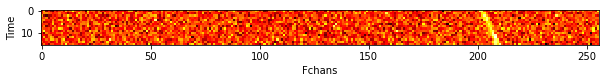

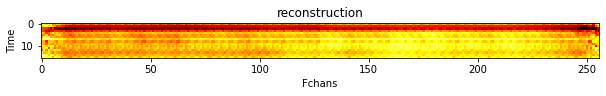

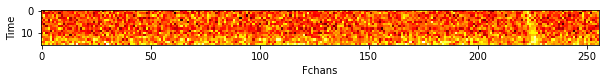

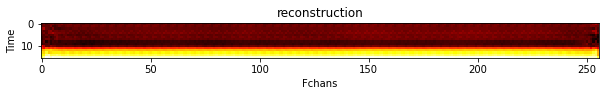

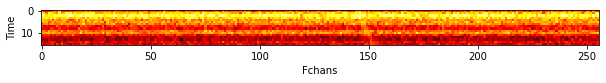

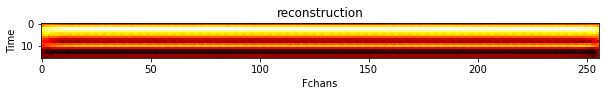

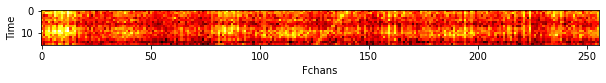

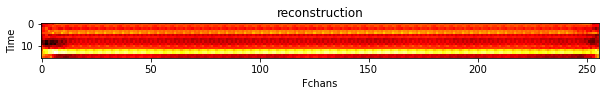

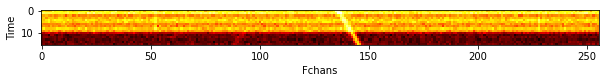

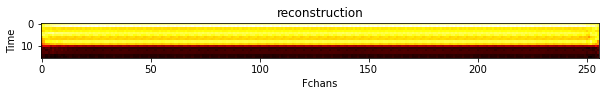

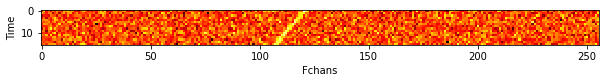

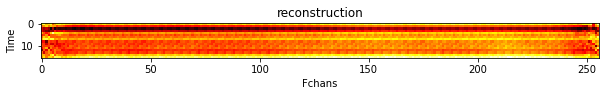

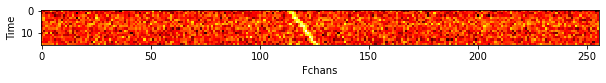

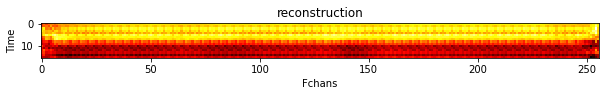

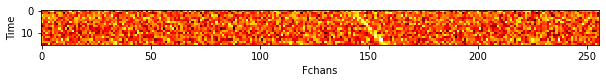

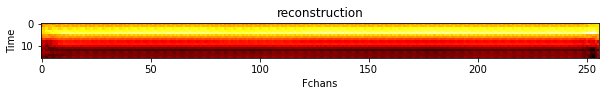

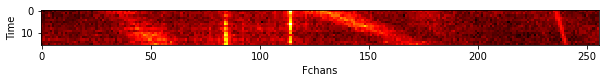

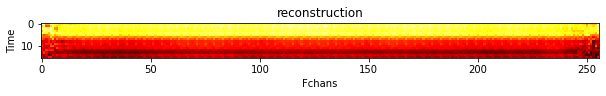

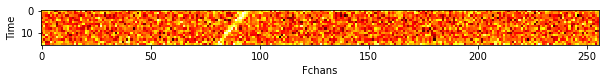

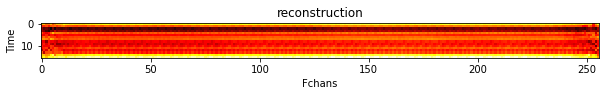

In [91]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()
  
    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
